# ***Implementasi Algoritma IndoBERT-Embedding dalam Analisis Sentimen Ulasan aplikasi eFootball  2025***

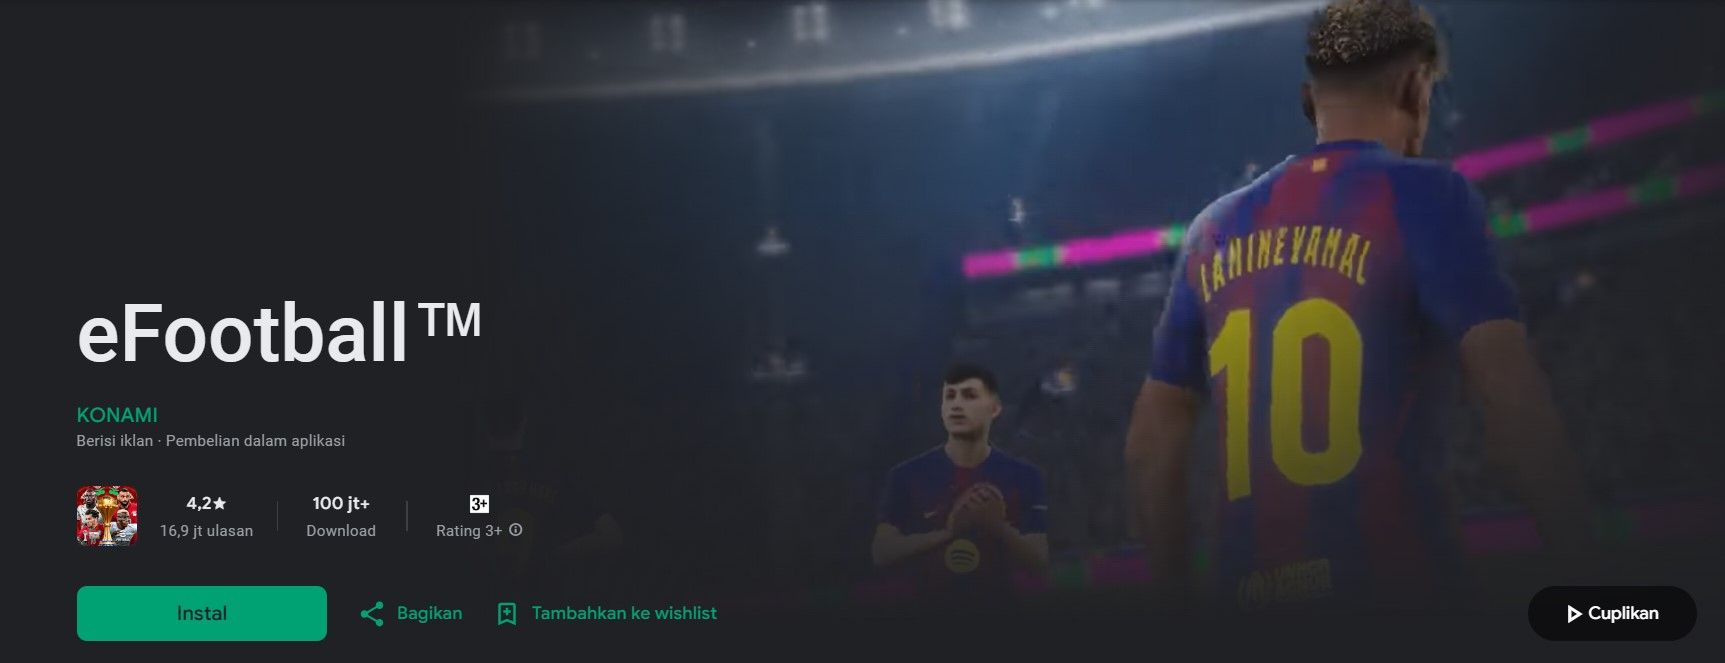

In [1]:
!pip install google-play-scraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00


In [2]:
from google_play_scraper import reviews, Sort
from datetime import datetime
import csv
import hashlib
import difflib

app_id = 'jp.konami.pesam'

def get_reviews_by_date(app_id, lang='id', country='id', count=10000, start_date='2025-01-01', end_date='2025-12-30'):
    all_reviews = []
    continuation_token = None

    start_dt = datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = datetime.strptime(end_date, "%Y-%m-%d")

    while True:
        try:
            result, continuation_token = reviews(
                app_id,
                lang=lang,
                country=country,
                sort=Sort.NEWEST,
                count=count,
                continuation_token=continuation_token
            )

            if not result:
                break

            for r in result:
                review_date = r.get('at')
                if review_date is None:
                    continue

                if start_dt <= review_date <= end_dt:
                    # Simpan hanya field penting
                    rec = {
                        'reviewId': r.get('reviewId'),
                        'userName': r.get('userName'),
                        'userImage': r.get('userImage'),
                        'score': r.get('score'),
                        'at': review_date.isoformat(),
                        'content': r.get('content'),
                        'thumbsUpCount': r.get('thumbsUp'),
                        'replyContent': r.get('replyContent'),
                        'replyAt': r.get('replyAt').isoformat() if r.get('replyAt') else None
                    }
                    all_reviews.append(rec)
                elif review_date < start_dt:
                    continuation_token = None
                    break

            if continuation_token is None:
                break

        except Exception as e:
            print("Error:", e)
            break

    return all_reviews

def fingerprint_text(text, n_chars=80):
    """Simple deterministic fingerprint of text (lowercased, trimmed)."""
    if not text:
        return None
    t = text.strip().lower()[:n_chars]
    return hashlib.sha1(t.encode('utf-8')).hexdigest()

def fingerprint_image(url):
    """Fingerprint an image URL (if available)."""
    if not url:
        return None
    return hashlib.sha1(url.encode('utf-8')).hexdigest()

def assign_probable_user_id(reviews):
    """
    Assign a probable_user_id for grouping:
    1) If userName is not 'Pengguna Google' -> use userName (normalized)
    2) Else if userImage available -> use hashed image fingerprint
    3) Else use text fingerprint of content
    This is heuristic only.
    """
    for r in reviews:
        uname = (r.get('userName') or '').strip()
        if uname and uname.lower() != 'pengguna google':
            # normalize small whitespace/case differences
            pid = 'name:' + '_'.join(uname.split()).lower()
        else:
            img_fp = fingerprint_image(r.get('userImage'))
            if img_fp:
                pid = 'img:' + img_fp
            else:
                txt_fp = fingerprint_text(r.get('content') or '')
                if txt_fp:
                    pid = 'txt:' + txt_fp
                else:
                    # fallback to reviewId (unique per review) so it won't group
                    pid = 'rid:' + (r.get('reviewId') or 'unknown')
        r['probable_user_id'] = pid

    TEXT_SIM_THRESHOLD = 0.92
    text_groups = {}
    for r in reviews:
        if r['probable_user_id'].startswith('txt:'):
            base_txt = (r.get('content') or '').strip()
            merged = False
            for key, rep in text_groups.items():
                ratio = difflib.SequenceMatcher(None, base_txt, rep['sample']).ratio()
                if ratio >= TEXT_SIM_THRESHOLD:
                    r['probable_user_id'] = key
                    merged = True
                    break
            if not merged:
                key = r['probable_user_id']
                text_groups[key] = {'sample': base_txt}
    return reviews

def save_reviews_to_csv(reviews, filename='hasil_scraper_ulasan_app_eFootball.csv'):
    headers = ['probable_user_id','reviewId','userName','userImage','score','at','content','thumbsUpCount','replyContent','replyAt']
    with open(filename, 'w', encoding='utf-8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=headers)
        writer.writeheader()
        for r in reviews:
            writer.writerow({k: r.get(k) for k in headers})
    print(f"Saved {len(reviews)} rows to {filename}")

# # ============================
# # Contoh pemakaian:
# # ============================

filtered_reviews = get_reviews_by_date(
    app_id,
    lang='id',
    country='id',
    count=10000,  # ambil per-request; besarkan kalau perlu
    start_date='2025-01-01',
    end_date='2025-12-30'
)

print("Total reviews fetched:", len(filtered_reviews))

if filtered_reviews:
    filtered_reviews = assign_probable_user_id(filtered_reviews)
    # contoh: print 10 pertama dengan probable_user_id
    for i, r in enumerate(filtered_reviews[:10], 1):
        print(f"\n[{i}] probable_user_id: {r['probable_user_id']}")
        print(" userName:", r['userName'])
        print(" userImage:", r['userImage'])
        print(" date:", r['at'])
        print(" score:", r['score'])
        print(" content:", (r['content'] or "")[:200])

    # Simpan ke CSV
    save_reviews_to_csv(filtered_reviews)

Total reviews fetched: 127021

[1] probable_user_id: img:c72c5fd7c20d0497d4a734ac427fe3d4a5b4e911
 userName: Pengguna Google
 userImage: https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g
 date: 2025-12-29T23:51:10
 score: 5
 content: min saya gapernah hoki kasih saya epic

[2] probable_user_id: img:c72c5fd7c20d0497d4a734ac427fe3d4a5b4e911
 userName: Pengguna Google
 userImage: https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g
 date: 2025-12-29T23:49:39
 score: 5
 content: tolong bikin jumlah kebobolan untuk kiper

[3] probable_user_id: img:c72c5fd7c20d0497d4a734ac427fe3d4a5b4e911
 userName: Pengguna Google
 userImage: https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g
 date: 2025-12-29T23:49:12
 score: 1
 content: ah bung kenapa kau menciptakan game rusak dan tidak jelas server

In [3]:
import pandas as pd

data = pd.read_csv("hasil_scraper_ulasan_app_eFootball.csv")
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127021 entries, 0 to 127020
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   probable_user_id  127021 non-null  object 
 1   reviewId          127021 non-null  object 
 2   userName          127021 non-null  object 
 3   userImage         127021 non-null  object 
 4   score             127021 non-null  int64  
 5   at                127021 non-null  object 
 6   content           127021 non-null  object 
 7   thumbsUpCount     0 non-null       float64
 8   replyContent      0 non-null       float64
 9   replyAt           0 non-null       float64
dtypes: float64(3), int64(1), object(6)
memory usage: 9.7+ MB


,probable_user_id,reviewId,userName,userImage,score,at,content,thumbsUpCount,replyContent,replyAt
0,img:c72c5fd7c20d0497d4a734ac427fe3d4a5b4e911,4b450123-bbf6-494b-886b-89a8905e0659,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,5,2025-12-29T23:51:10,min saya gapernah hoki kasih saya epic,NaN,NaN,NaN
1,img:c72c5fd7c20d0497d4a734ac427fe3d4a5b4e911,5024c714-385c-476a-85ea-7e9bed041f9c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,5,2025-12-29T23:49:39,tolong bikin jumlah kebobolan untuk kiper,NaN,NaN,NaN
2,img:c72c5fd7c20d0497d4a734ac427fe3d4a5b4e911,5ed8a257-12e0-4f0c-a99c-131808041c33,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,1,2025-12-29T23:49:12,ah bung kenapa kau menciptakan game rusak dan ...,NaN,NaN,NaN
3,img:c72c5fd7c20d0497d4a734ac427fe3d4a5b4e911,f1c1c899-4a7b-4273-8306-e585814a4bde,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,5,2025-12-29T23:27:36,wow,NaN,NaN,NaN
4,img:c72c5fd7c20d0497d4a734ac427fe3d4a5b4e911,05602c10-5a72-4ec5-938b-2b1c778440d9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,1,2025-12-29T23:24:59,"eh Konami mentang"" gua ga topap game lo, lo ka...",NaN,NaN,NaN


 ***TEXT PREPROCESSING DATA***

In [4]:
# ubah kolom ke datetime (aman jika masih string)
data['at'] = pd.to_datetime(data['at'])

# pisahkan tanggal dan waktu
data['tanggal'] = data['at'].dt.date
data['waktu']   = data['at'].dt.time

data.head()

,probable_user_id,reviewId,userName,userImage,score,at,content,thumbsUpCount,replyContent,replyAt,tanggal,waktu
0,img:c72c5fd7c20d0497d4a734ac427fe3d4a5b4e911,4b450123-bbf6-494b-886b-89a8905e0659,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,5,2025-12-29 23:51:10,min saya gapernah hoki kasih saya epic,NaN,NaN,NaN,2025-12-29,23:51:10
1,img:c72c5fd7c20d0497d4a734ac427fe3d4a5b4e911,5024c714-385c-476a-85ea-7e9bed041f9c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,5,2025-12-29 23:49:39,tolong bikin jumlah kebobolan untuk kiper,NaN,NaN,NaN,2025-12-29,23:49:39
2,img:c72c5fd7c20d0497d4a734ac427fe3d4a5b4e911,5ed8a257-12e0-4f0c-a99c-131808041c33,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,1,2025-12-29 23:49:12,ah bung kenapa kau menciptakan game rusak dan ...,NaN,NaN,NaN,2025-12-29,23:49:12
3,img:c72c5fd7c20d0497d4a734ac427fe3d4a5b4e911,f1c1c899-4a7b-4273-8306-e585814a4bde,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,5,2025-12-29 23:27:36,wow,NaN,NaN,NaN,2025-12-29,23:27:36
4,img:c72c5fd7c20d0497d4a734ac427fe3d4a5b4e911,05602c10-5a72-4ec5-938b-2b1c778440d9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,1,2025-12-29 23:24:59,"eh Konami mentang"" gua ga topap game lo, lo ka...",NaN,NaN,NaN,2025-12-29,23:24:59


In [5]:
df  = pd.DataFrame(data[['tanggal','waktu','score','content']])
df.head(10)

,tanggal,waktu,score,content
0,2025-12-29,23:51:10,5,min saya gapernah hoki kasih saya epic
1,2025-12-29,23:49:39,5,tolong bikin jumlah kebobolan untuk kiper
2,2025-12-29,23:49:12,1,ah bung kenapa kau menciptakan game rusak dan ...
3,2025-12-29,23:27:36,5,wow
4,2025-12-29,23:24:59,1,"eh Konami mentang"" gua ga topap game lo, lo ka..."
5,2025-12-29,23:24:04,5,komnain baik hati
6,2025-12-29,22:43:14,1,kalau main divisi ngotak dikit lh naik poin se...
7,2025-12-29,22:30:28,3,setelah upgrade ko koneksi nya jelek ya... pad...
8,2025-12-29,22:28:55,1,"tolong level bot AI benar benar disesuaikan, k..."
9,2025-12-29,22:25:27,1,"The game seems to support Barcelona, that's wh..."


**PROSES CLEANING**


PROSES HAPUS DATA DUPLIKAT

In [6]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127021 entries, 0 to 127020
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   tanggal  127021 non-null  object
 1   waktu    127021 non-null  object
 2   score    127021 non-null  int64 
 3   content  127021 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.9+ MB


,tanggal,waktu,score,content
0,2025-12-29,23:51:10,5,min saya gapernah hoki kasih saya epic
1,2025-12-29,23:49:39,5,tolong bikin jumlah kebobolan untuk kiper
2,2025-12-29,23:49:12,1,ah bung kenapa kau menciptakan game rusak dan ...
3,2025-12-29,23:27:36,5,wow
4,2025-12-29,23:24:59,1,"eh Konami mentang"" gua ga topap game lo, lo ka..."


In [7]:
#jumlah data duplikat

data = df[df.duplicated(subset="content", keep=False)]
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 31030 entries, 3 to 127020
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tanggal  31030 non-null  object
 1   waktu    31030 non-null  object
 2   score    31030 non-null  int64 
 3   content  31030 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


,tanggal,waktu,score,content
3,2025-12-29,23:27:36,5,wow
12,2025-12-29,21:15:44,5,good game
13,2025-12-29,20:32:56,5,mantap
26,2025-12-29,18:13:29,1,game stress
37,2025-12-29,17:10:06,1,game eek


In [8]:
#hapus duplikast data

df.drop_duplicates(subset ="content", inplace = True)
df.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 98646 entries, 0 to 127019
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tanggal  98646 non-null  object
 1   waktu    98646 non-null  object
 2   score    98646 non-null  int64 
 3   content  98646 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.8+ MB


,tanggal,waktu,score,content
3,2025-12-29,23:27:36,5,wow
12,2025-12-29,21:15:44,5,good game
13,2025-12-29,20:32:56,5,mantap
26,2025-12-29,18:13:29,1,game stress
37,2025-12-29,17:10:06,1,game eek


In [9]:
import re
import string
import nltk

# Fungsi untuk menghapus URL
def remove_URL(tweet):
    if tweet is not None and isinstance(tweet, str):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'', tweet)
    else:
        return tweet


# Fungsi untuk menghapus emoji
def remove_emoji(tweet):
    if tweet is not None and isinstance(tweet, str):
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F700-\U0001F77F"  # alchemical symbols
            u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
            u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
            u"\U0001FA00-\U0001FA6F"  # Chess Symbols
            u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
            u"\U0001F004-\U0001F0CF"  # Additional emoticons
            u"\U0001F1E0-\U0001F1FF"  # flags
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', tweet)
    else:
        return tweet

# Fungsi untuk menghapus simbol
def remove_symbols(tweet):
    if tweet is not None and isinstance(tweet, str):
        tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    return tweet

# Fungsi untuk menghapus angka
def remove_numbers(tweet):
    if tweet is not None and isinstance(tweet, str):
        tweet = re.sub(r'\d', '', tweet)
    return tweet

# Fungsi hapus username
def remove_usernames(text):
    if text is not None and isinstance(text, str):
        return re.sub(r'@\w+', '', text)
    else:
        return text

df['cleaning'] = df['content'].apply(lambda x: remove_URL(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_usernames(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_emoji(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_symbols(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_numbers(x))

df.head(5)

,tanggal,waktu,score,content,cleaning
0,2025-12-29,23:51:10,5,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic
1,2025-12-29,23:49:39,5,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper
2,2025-12-29,23:49:12,1,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...
3,2025-12-29,23:27:36,5,wow,wow
4,2025-12-29,23:24:59,1,"eh Konami mentang"" gua ga topap game lo, lo ka...",eh Konami mentang gua ga topap game lo lo kasi...


**PROSES CASE FOLDING**

---



In [10]:
def case_folding(text):
    if isinstance(text, str):
        lowercase_text = text.lower()
        return lowercase_text
    else:
        return text

df['case_folding'] = df['cleaning'].apply(case_folding)
df.head(5)

,tanggal,waktu,score,content,cleaning,case_folding
0,2025-12-29,23:51:10,5,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic
1,2025-12-29,23:49:39,5,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper
2,2025-12-29,23:49:12,1,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...
3,2025-12-29,23:27:36,5,wow,wow,wow
4,2025-12-29,23:24:59,1,"eh Konami mentang"" gua ga topap game lo, lo ka...",eh Konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua ga topap game lo lo kasi...


**Normalisasi Kata**

---



In [11]:
import pandas as pd
import requests
from io import BytesIO

# Fungsi penggantian kata tidak baku
def replace_taboo_words(text, kamus_tidak_baku):
    if isinstance(text, str):
        words = text.split()
        replaced_words = []
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []

        for word in words:
            if word in kamus_tidak_baku:
                baku_word = kamus_tidak_baku[word]
                if isinstance(baku_word, str) and all(char.isalpha() for char in baku_word):
                    replaced_words.append(baku_word)
                    kalimat_baku.append(baku_word)
                    kata_diganti.append(word)
                    kata_tidak_baku_hash.append(hash(word))
            else:
                replaced_words.append(word)
        replaced_text = ' '.join(replaced_words)
    else:
        replaced_text = ''
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []

    return replaced_text, kalimat_baku, kata_diganti, kata_tidak_baku_hash

# Baca dataset kamu (pastikan df sudah tersedia)
data = pd.DataFrame(df[['tanggal','waktu','score','content','cleaning','case_folding']])
data.head()

,tanggal,waktu,score,content,cleaning,case_folding
0,2025-12-29,23:51:10,5,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic
1,2025-12-29,23:49:39,5,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper
2,2025-12-29,23:49:12,1,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...
3,2025-12-29,23:27:36,5,wow,wow,wow
4,2025-12-29,23:24:59,1,"eh Konami mentang"" gua ga topap game lo, lo ka...",eh Konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua ga topap game lo lo kasi...


In [12]:
# Unduh dan baca kamus dari GitHub
url = "https://github.com/analysisdatasentiment/kamus_kata_baku/raw/main/kamuskatabaku.xlsx"
response = requests.get(url)
file_excel = BytesIO(response.content)
kamus_data = pd.read_excel(file_excel)

# Buat dictionary dari kamus
kamus_tidak_baku_dict = dict(zip(kamus_data['tidak_baku'], kamus_data['kata_baku']))

In [13]:
# Terapkan fungsi normalisasi
data[['normalisasi', 'Kata_Baku', 'Kata_Tidak_Baku', 'Kata_Tidak_Baku_Hash']] = data['case_folding'].apply(
    lambda x: pd.Series(replace_taboo_words(x, kamus_tidak_baku_dict))
)

# Ambil kolom yang relevan
df = pd.DataFrame(data[['tanggal','waktu','score','content','cleaning','case_folding','normalisasi']])
df.head(5)

,tanggal,waktu,score,content,cleaning,case_folding,normalisasi
0,2025-12-29,23:51:10,5,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya hoki kasih saya epic
1,2025-12-29,23:49:39,5,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper
2,2025-12-29,23:49:12,1,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...
3,2025-12-29,23:27:36,5,wow,wow,wow,wow
4,2025-12-29,23:24:59,1,"eh Konami mentang"" gua ga topap game lo, lo ka...",eh Konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua tidak topap game lo lo k...


**TOKENIZATION**

---

In [14]:
def tokenize(text):
    tokens = text.split()
    return tokens

df['tokenize'] = df['normalisasi'].apply(tokenize)

df.head(5)

,tanggal,waktu,score,content,cleaning,case_folding,normalisasi,tokenize
0,2025-12-29,23:51:10,5,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya hoki kasih saya epic,"[min, saya, hoki, kasih, saya, epic]"
1,2025-12-29,23:49:39,5,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,"[tolong, bikin, jumlah, kebobolan, untuk, kiper]"
2,2025-12-29,23:49:12,1,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,"[ah, bung, kenapa, kau, menciptakan, game, rus..."
3,2025-12-29,23:27:36,5,wow,wow,wow,wow,[wow]
4,2025-12-29,23:24:59,1,"eh Konami mentang"" gua ga topap game lo, lo ka...",eh Konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua tidak topap game lo lo k...,"[eh, konami, mentang, gua, tidak, topap, game,..."


**PROSES STOPWORD REMOVAL**

---



In [15]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

# Ubah hasil list jadi string
df['stopword removal'] = df['tokenize'].apply(
    lambda x: " ".join(remove_stopwords(x))
)

df.head(5)

,tanggal,waktu,score,content,cleaning,case_folding,normalisasi,tokenize,stopword removal
0,2025-12-29,23:51:10,5,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya hoki kasih saya epic,"[min, saya, hoki, kasih, saya, epic]",min hoki kasih epic
1,2025-12-29,23:49:39,5,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,"[tolong, bikin, jumlah, kebobolan, untuk, kiper]",tolong bikin kebobolan kiper
2,2025-12-29,23:49:12,1,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,"[ah, bung, kenapa, kau, menciptakan, game, rus...",ah kau menciptakan game rusak server sistem ya...
3,2025-12-29,23:27:36,5,wow,wow,wow,wow,[wow],wow
4,2025-12-29,23:24:59,1,"eh Konami mentang"" gua ga topap game lo, lo ka...",eh Konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua tidak topap game lo lo k...,"[eh, konami, mentang, gua, tidak, topap, game,...",eh konami mentang gua topap game lo lo kasih l...


In [17]:
from collections import Counter

all_text = ' '.join(df['stopword removal'].astype(str))
all_text = re.sub(r'[^a-zA-Z\s]', '', all_text.lower())

word_list = all_text.split()
word_freq = Counter(word_list)

sorted_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
df_freq = pd.DataFrame(sorted_freq, columns=['Kata', 'Frekuensi'])

df_freq.to_csv('frekuensi_kata_awal.csv', index=False)
print("✅ File 'frekuensi_kata_awal.csv' berhasil disimpan.")
df_freq.info()
df_freq.head(50)

✅ File 'frekuensi_kata_awal.csv' berhasil disimpan.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47290 entries, 0 to 47289
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Kata       47290 non-null  object
 1   Frekuensi  47290 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 739.0+ KB


,Kata,Frekuensi
0,game,38566
1,ya,31866
2,bagus,23680
3,main,13665
4,tolong,12966
5,update,11795
6,pemain,11378
7,banget,9029
8,konami,8901
9,jaringan,7171


In [18]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 98646 entries, 0 to 127019
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tanggal           98646 non-null  object
 1   waktu             98646 non-null  object
 2   score             98646 non-null  int64 
 3   content           98646 non-null  object
 4   cleaning          98646 non-null  object
 5   case_folding      98646 non-null  object
 6   normalisasi       98646 non-null  object
 7   tokenize          98646 non-null  object
 8   stopword removal  98646 non-null  object
dtypes: int64(1), object(8)
memory usage: 9.5+ MB


,tanggal,waktu,score,content,cleaning,case_folding,normalisasi,tokenize,stopword removal
0,2025-12-29,23:51:10,5,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya hoki kasih saya epic,"[min, saya, hoki, kasih, saya, epic]",min hoki kasih epic
1,2025-12-29,23:49:39,5,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,"[tolong, bikin, jumlah, kebobolan, untuk, kiper]",tolong bikin kebobolan kiper
2,2025-12-29,23:49:12,1,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,"[ah, bung, kenapa, kau, menciptakan, game, rus...",ah kau menciptakan game rusak server sistem ya...
3,2025-12-29,23:27:36,5,wow,wow,wow,wow,[wow],wow
4,2025-12-29,23:24:59,1,"eh Konami mentang"" gua ga topap game lo, lo ka...",eh Konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua tidak topap game lo lo k...,"[eh, konami, mentang, gua, tidak, topap, game,...",eh konami mentang gua topap game lo lo kasih l...


In [19]:
hapus_kata = ['ya','the','i','sih','sok','for','nih','is','ok','gpt','a','oke','qr','pas','spx','gue','ku','and','my']

# hapus kata dari teks
df['stopword removal'] = df['stopword removal'].apply(
    lambda x: ' '.join([kata for kata in x.split() if kata not in hapus_kata]))

df['stopword removal'].str.contains('|'.join(hapus_kata)).sum()
df.head()

,tanggal,waktu,score,content,cleaning,case_folding,normalisasi,tokenize,stopword removal
0,2025-12-29,23:51:10,5,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya hoki kasih saya epic,"[min, saya, hoki, kasih, saya, epic]",min hoki kasih epic
1,2025-12-29,23:49:39,5,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,"[tolong, bikin, jumlah, kebobolan, untuk, kiper]",tolong bikin kebobolan kiper
2,2025-12-29,23:49:12,1,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,"[ah, bung, kenapa, kau, menciptakan, game, rus...",ah kau menciptakan game rusak server sistem ke...
3,2025-12-29,23:27:36,5,wow,wow,wow,wow,[wow],wow
4,2025-12-29,23:24:59,1,"eh Konami mentang"" gua ga topap game lo, lo ka...",eh Konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua tidak topap game lo lo k...,"[eh, konami, mentang, gua, tidak, topap, game,...",eh konami mentang gua topap game lo lo kasih l...


In [20]:
# ---  Membuat kamus kata tidak baku -> kata baku
kamus_tidak_baku = {
    'apk':'aplikasi',
    'app':'aplikasi',
    'ngedit':'edit',
    'hp':'handphone'
}

def perbaiki_kata(teks):
    kata_list = teks.split()
    hasil = [kamus_tidak_baku.get(kata, kata) for kata in kata_list]
    return ' '.join(hasil)

df['stopword removal'] = df['stopword removal'].astype(str).apply(perbaiki_kata)
df.head(5)

,tanggal,waktu,score,content,cleaning,case_folding,normalisasi,tokenize,stopword removal
0,2025-12-29,23:51:10,5,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya hoki kasih saya epic,"[min, saya, hoki, kasih, saya, epic]",min hoki kasih epic
1,2025-12-29,23:49:39,5,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,"[tolong, bikin, jumlah, kebobolan, untuk, kiper]",tolong bikin kebobolan kiper
2,2025-12-29,23:49:12,1,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,"[ah, bung, kenapa, kau, menciptakan, game, rus...",ah kau menciptakan game rusak server sistem ke...
3,2025-12-29,23:27:36,5,wow,wow,wow,wow,[wow],wow
4,2025-12-29,23:24:59,1,"eh Konami mentang"" gua ga topap game lo, lo ka...",eh Konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua tidak topap game lo lo k...,"[eh, konami, mentang, gua, tidak, topap, game,...",eh konami mentang gua topap game lo lo kasih l...


In [21]:
from collections import Counter
import re

all_text = ' '.join(df['stopword removal'].astype(str))
all_text = re.sub(r'[^a-zA-Z\s]', '', all_text.lower())

word_list = all_text.split()
word_freq = Counter(word_list)

sorted_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
df_freq = pd.DataFrame(sorted_freq, columns=['Kata', 'Frekuensi'])

# df_freq.info()
df_freq.head(50)

,Kata,Frekuensi
0,game,38566
1,bagus,23680
2,main,13665
3,tolong,12966
4,update,11795
5,pemain,11378
6,banget,9029
7,konami,8901
8,jaringan,7171
9,liga,6371


**WORDCLOUD SETELAH PREPROCESSING**

---



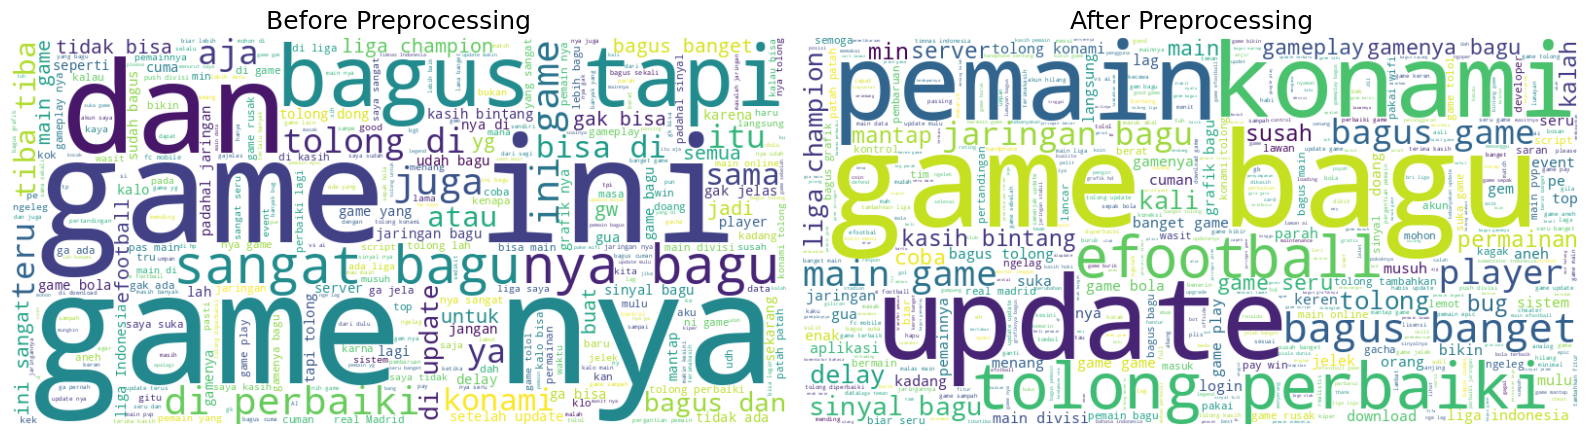

In [22]:
import pandas as pd
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

# Buat stopwords tambahan
stopwords = set(STOPWORDS)
stopwords.update(['https', 'co', 'RT', '...', 'amp', 'kayak', 'lu', 'deh'])

# WordCloud Before (dari kolom 'Review Text')
text_before = ' '.join(
    df['content']
    .astype(str)
    .tolist()
)

wc_before = WordCloud(
    stopwords=stopwords,
    background_color="white",
    max_words=500,
    width=800,
    height=400
).generate(text_before)

# WordCloud After (dari kolom 'stopword removal')
text_after = ' '.join(
    [" ".join(eval(x) if isinstance(x, str) and x.startswith('[') else x.split())
     for x in df['stopword removal'].astype(str)]
)

wc_after = WordCloud(
    stopwords=stopwords,
    background_color="white",
    max_words=500,
    width=800,
    height=400
).generate(text_after)

# Visualisasi side-by-side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wc_before, interpolation='bilinear')
plt.axis("off")
plt.title("Before Preprocessing", fontsize=18)

plt.subplot(1, 2, 2)
plt.imshow(wc_after, interpolation='bilinear')
plt.axis("off")
plt.title("After Preprocessing", fontsize=18)

plt.tight_layout()
plt.show()


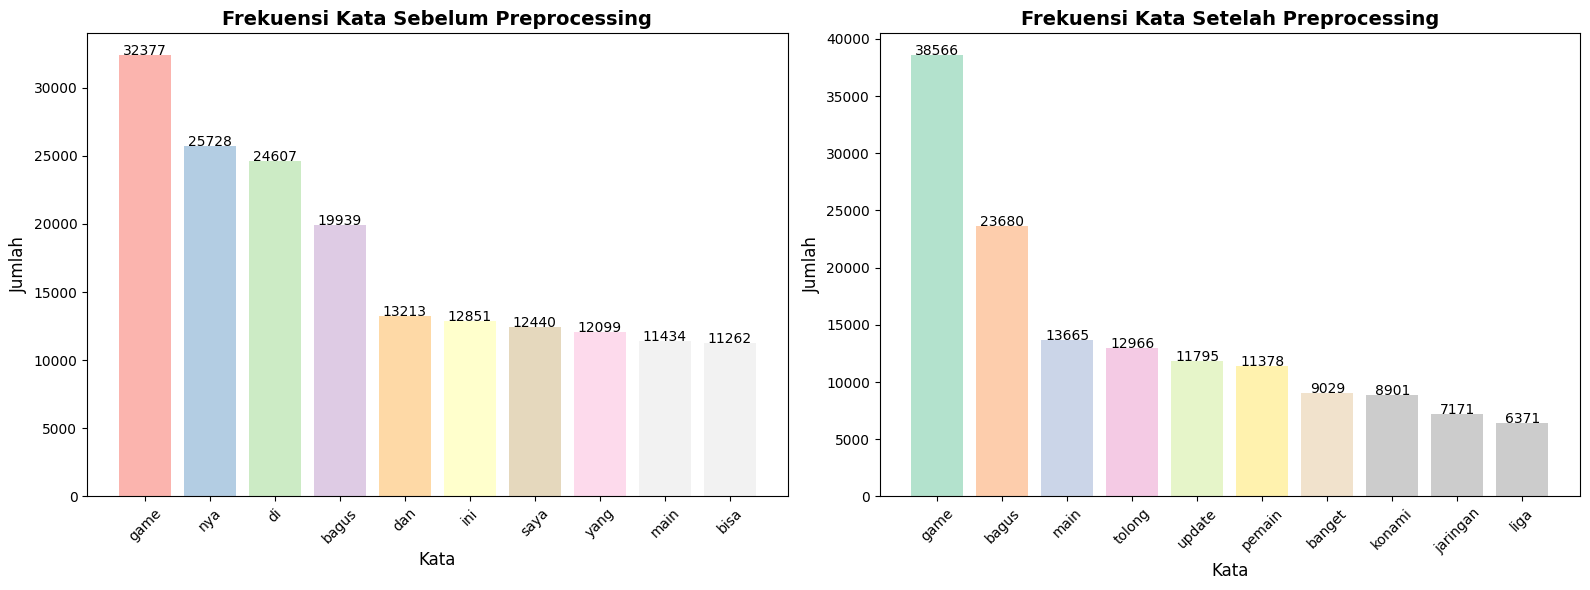

In [23]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import STOPWORDS


# Set stopwords tambahan
stopwords = set(STOPWORDS)
stopwords.update(['https', 'co', 'RT', '...', 'amp', 'lu', 'deh', 'fyp', 'ya'])

# Fungsi helper untuk membersihkan tanda kutip, [ ], , dll
def clean_text_column(series):
    cleaned = []
    for text in series.astype(str):
        # Hapus [ ], tanda petik tunggal/ganda, koma
        text = re.sub(r"[\[\]\'\",]", "", text)
        cleaned.append(text.strip())
    return " ".join(cleaned)

# BEFORE: kolom
all_text_before = clean_text_column(df["content"])
words_before = all_text_before.split()
filtered_words_before = [word for word in words_before if word.lower() not in stopwords]
word_counts_before = Counter(filtered_words_before)
top_words_before = word_counts_before.most_common(10)
word_before, count_before = zip(*top_words_before)

# AFTER: kolom
all_text_after = clean_text_column(df["stopword removal"])
words_after = all_text_after.split()
filtered_words_after = [word for word in words_after if word.lower() not in stopwords]
word_counts_after = Counter(filtered_words_after)
top_words_after = word_counts_after.most_common(10)
word_after, count_after = zip(*top_words_after)

# Plot berdampingan
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# BEFORE Plot
colors_before = plt.cm.Pastel1(range(len(word_before)))
bars1 = axes[0].bar(word_before, count_before, color=colors_before)
axes[0].set_title("Frekuensi Kata Sebelum Preprocessing", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Kata", fontsize=12)
axes[0].set_ylabel("Jumlah", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
for bar, count in zip(bars1, count_before):
    axes[0].text(bar.get_x() + bar.get_width()/2, count + 1, str(count), ha='center')

# AFTER Plot
colors_after = plt.cm.Pastel2(range(len(word_after)))
bars2 = axes[1].bar(word_after, count_after, color=colors_after)
axes[1].set_title("Frekuensi Kata Setelah Preprocessing", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Kata", fontsize=12)
axes[1].set_ylabel("Jumlah", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
for bar, count in zip(bars2, count_after):
    axes[1].text(bar.get_x() + bar.get_width()/2, count + 1, str(count), ha='center')

plt.tight_layout()
plt.show()

In [24]:
df.to_csv('Hasil_Preprocessing_Data.csv',encoding='utf8', index=False);

# ***PELEBALAN DATA RATING 2 CLASS (1-3 Negatif, 4-5 Positif)***

In [25]:
import pandas as pd

data = pd.read_csv("Hasil_Preprocessing_Data.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98646 entries, 0 to 98645
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tanggal           98646 non-null  object
 1   waktu             98646 non-null  object
 2   score             98646 non-null  int64 
 3   content           98646 non-null  object
 4   cleaning          98245 non-null  object
 5   case_folding      98245 non-null  object
 6   normalisasi       98150 non-null  object
 7   tokenize          98646 non-null  object
 8   stopword removal  97736 non-null  object
dtypes: int64(1), object(8)
memory usage: 6.8+ MB


,tanggal,waktu,score,content,cleaning,case_folding,normalisasi,tokenize,stopword removal
0,2025-12-29,23:51:10,5,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya hoki kasih saya epic,"['min', 'saya', 'hoki', 'kasih', 'saya', 'epic']",min hoki kasih epic
1,2025-12-29,23:49:39,5,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,"['tolong', 'bikin', 'jumlah', 'kebobolan', 'un...",tolong bikin kebobolan kiper
2,2025-12-29,23:49:12,1,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,"['ah', 'bung', 'kenapa', 'kau', 'menciptakan',...",ah kau menciptakan game rusak server sistem ke...
3,2025-12-29,23:27:36,5,wow,wow,wow,wow,['wow'],wow
4,2025-12-29,23:24:59,1,"eh Konami mentang"" gua ga topap game lo, lo ka...",eh Konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua tidak topap game lo lo k...,"['eh', 'konami', 'mentang', 'gua', 'tidak', 't...",eh konami mentang gua topap game lo lo kasih l...


In [26]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97736 entries, 0 to 98645
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tanggal           97736 non-null  object
 1   waktu             97736 non-null  object
 2   score             97736 non-null  int64 
 3   content           97736 non-null  object
 4   cleaning          97736 non-null  object
 5   case_folding      97736 non-null  object
 6   normalisasi       97736 non-null  object
 7   tokenize          97736 non-null  object
 8   stopword removal  97736 non-null  object
dtypes: int64(1), object(8)
memory usage: 7.5+ MB


In [27]:
data = pd.DataFrame(data[['stopword removal','score']])
data.head(5)

,stopword removal,score
0,min hoki kasih epic,5
1,tolong bikin kebobolan kiper,5
2,ah kau menciptakan game rusak server sistem ke...,1
3,wow,5
4,eh konami mentang gua topap game lo lo kasih l...,1


In [28]:
def label_sentimen(score):
    if score in [1, 2, 3]:
        return 'Negatif'
    elif score in [4, 5]:
        return 'Positif'
    else:
        return 'tidak valid'

# Terapkan fungsi ke kolom score
data['Sentiment'] = data['score'].apply(label_sentimen)
data.head(20)

,stopword removal,score,Sentiment
0,min hoki kasih epic,5,Positif
1,tolong bikin kebobolan kiper,5,Positif
2,ah kau menciptakan game rusak server sistem ke...,1,Negatif
3,wow,5,Positif
4,eh konami mentang gua topap game lo lo kasih l...,1,Negatif
5,komnain hati,5,Positif
6,main divisi ngotak dikit poin giliran nurun ma...,1,Negatif
7,upgrade koneksi jelek koneksi internet stabil,3,Negatif
8,tolong level bot ai disesuaikan kadang main le...,1,Negatif
9,game seems support barcelona thats why uninsta...,1,Negatif


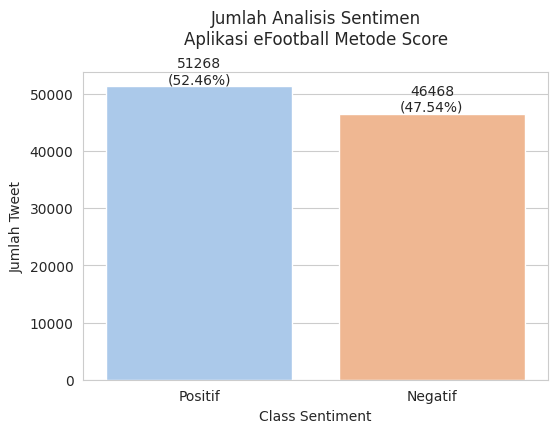

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Menghitung jumlah sentimen

sentiment_count = data['Sentiment'].value_counts()
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette='pastel')
plt.title('Jumlah Analisis Sentimen\nAplikasi eFootball Metode Score', fontsize=12, pad=20)
plt.xlabel('Class Sentiment', fontsize=10)
plt.ylabel('Jumlah Tweet', fontsize=10)

total = len(data['Sentiment'])

for i, count in enumerate(sentiment_count.values):
    percentage = f'{100 * count / total:.2f}%'
    ax.text(i, count + 0.10, f'{count}\n({percentage})', ha='center', va='bottom')

plt.show()

In [30]:
data.to_csv('Hasil_Labelling_Data_scrore2.csv',encoding='utf8', index=False)

# ***PELEBALAN DATA METODE LAXICON BASED 2 CLASS***

In [31]:
import pandas as pd

data = pd.read_csv("Hasil_Preprocessing_Data.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98646 entries, 0 to 98645
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tanggal           98646 non-null  object
 1   waktu             98646 non-null  object
 2   score             98646 non-null  int64 
 3   content           98646 non-null  object
 4   cleaning          98245 non-null  object
 5   case_folding      98245 non-null  object
 6   normalisasi       98150 non-null  object
 7   tokenize          98646 non-null  object
 8   stopword removal  97736 non-null  object
dtypes: int64(1), object(8)
memory usage: 6.8+ MB


,tanggal,waktu,score,content,cleaning,case_folding,normalisasi,tokenize,stopword removal
0,2025-12-29,23:51:10,5,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya hoki kasih saya epic,"['min', 'saya', 'hoki', 'kasih', 'saya', 'epic']",min hoki kasih epic
1,2025-12-29,23:49:39,5,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,"['tolong', 'bikin', 'jumlah', 'kebobolan', 'un...",tolong bikin kebobolan kiper
2,2025-12-29,23:49:12,1,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,"['ah', 'bung', 'kenapa', 'kau', 'menciptakan',...",ah kau menciptakan game rusak server sistem ke...
3,2025-12-29,23:27:36,5,wow,wow,wow,wow,['wow'],wow
4,2025-12-29,23:24:59,1,"eh Konami mentang"" gua ga topap game lo, lo ka...",eh Konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua tidak topap game lo lo k...,"['eh', 'konami', 'mentang', 'gua', 'tidak', 't...",eh konami mentang gua topap game lo lo kasih l...


In [32]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97736 entries, 0 to 98645
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tanggal           97736 non-null  object
 1   waktu             97736 non-null  object
 2   score             97736 non-null  int64 
 3   content           97736 non-null  object
 4   cleaning          97736 non-null  object
 5   case_folding      97736 non-null  object
 6   normalisasi       97736 non-null  object
 7   tokenize          97736 non-null  object
 8   stopword removal  97736 non-null  object
dtypes: int64(1), object(8)
memory usage: 7.5+ MB


In [33]:
data = pd.DataFrame(data[['stopword removal']])
data.head(5)

,stopword removal
0,min hoki kasih epic
1,tolong bikin kebobolan kiper
2,ah kau menciptakan game rusak server sistem ke...
3,wow
4,eh konami mentang gua topap game lo lo kasih l...


In [34]:
import pandas as pd
import requests

# Unduh kamus leksikon positif dan negatif dari GitHub
positive_url = "https://raw.githubusercontent.com/fajri91/InSet/master/positive.tsv"
negative_url = "https://raw.githubusercontent.com/fajri91/InSet/master/negative.tsv"

positive_lexicon = set(pd.read_csv(positive_url, sep="\t", header=None)[0])
negative_lexicon = set(pd.read_csv(negative_url, sep="\t", header=None)[0])

def determine_sentiment(text):
    if isinstance(text, str):
        positive_count = sum(1 for word in text.split() if word in positive_lexicon)
        negative_count = sum(1 for word in text.split() if word in negative_lexicon)
        sentiment_score = positive_count - negative_count
        sentiment = "Negatif" if sentiment_score < 0 else "Positif"
        return sentiment_score, sentiment
    return 0, "Negatif"

data[['Score', 'Sentiment']] = data['stopword removal'].apply(lambda x: pd.Series(determine_sentiment(x)))
data.head(10)


,stopword removal,Score,Sentiment
0,min hoki kasih epic,0,Positif
1,tolong bikin kebobolan kiper,0,Positif
2,ah kau menciptakan game rusak server sistem ke...,-3,Negatif
3,wow,0,Positif
4,eh konami mentang gua topap game lo lo kasih l...,-1,Negatif
5,komnain hati,0,Positif
6,main divisi ngotak dikit poin giliran nurun ma...,0,Positif
7,upgrade koneksi jelek koneksi internet stabil,0,Positif
8,tolong level bot ai disesuaikan kadang main le...,0,Positif
9,game seems support barcelona thats why uninsta...,1,Positif


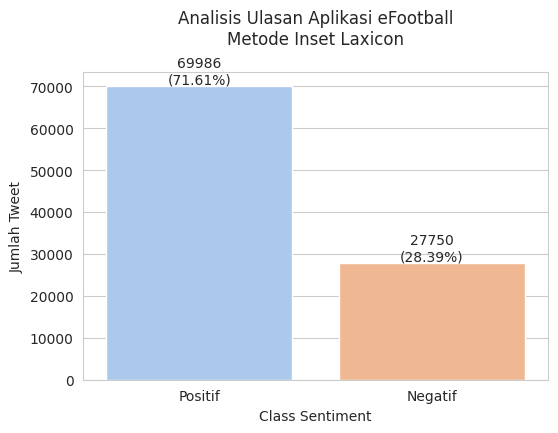

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sentiment_count = data['Sentiment'].value_counts()
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette='pastel')
plt.title('Analisis Ulasan Aplikasi eFootball\nMetode Inset Laxicon', fontsize=12, pad=20)
plt.xlabel('Class Sentiment', fontsize=10)
plt.ylabel('Jumlah Tweet', fontsize=10)

total = len(data['Sentiment'])

for i, count in enumerate(sentiment_count.values):
    percentage = f'{100 * count / total:.2f}%'
    ax.text(i, count + 0.10, f'{count}\n({percentage})', ha='center', va='bottom')

plt.show()

In [36]:
data.to_csv('Hasil_Labelling_Data_2Lax.csv',encoding='utf8', index=False)

# ***Aspect-based Sentiment Classification (ABSC) | Multi Class***

In [37]:
import pandas as pd

data = pd.read_csv("Hasil_Preprocessing_Data.csv")
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98646 entries, 0 to 98645
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tanggal           98646 non-null  object
 1   waktu             98646 non-null  object
 2   score             98646 non-null  int64 
 3   content           98646 non-null  object
 4   cleaning          98245 non-null  object
 5   case_folding      98245 non-null  object
 6   normalisasi       98150 non-null  object
 7   tokenize          98646 non-null  object
 8   stopword removal  97736 non-null  object
dtypes: int64(1), object(8)
memory usage: 6.8+ MB


,tanggal,waktu,score,content,cleaning,case_folding,normalisasi,tokenize,stopword removal
0,2025-12-29,23:51:10,5,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya gapernah hoki kasih saya epic,min saya hoki kasih saya epic,"['min', 'saya', 'hoki', 'kasih', 'saya', 'epic']",min hoki kasih epic
1,2025-12-29,23:49:39,5,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,tolong bikin jumlah kebobolan untuk kiper,"['tolong', 'bikin', 'jumlah', 'kebobolan', 'un...",tolong bikin kebobolan kiper
2,2025-12-29,23:49:12,1,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,ah bung kenapa kau menciptakan game rusak dan ...,"['ah', 'bung', 'kenapa', 'kau', 'menciptakan',...",ah kau menciptakan game rusak server sistem ke...
3,2025-12-29,23:27:36,5,wow,wow,wow,wow,['wow'],wow
4,2025-12-29,23:24:59,1,"eh Konami mentang"" gua ga topap game lo, lo ka...",eh Konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua ga topap game lo lo kasi...,eh konami mentang gua tidak topap game lo lo k...,"['eh', 'konami', 'mentang', 'gua', 'tidak', 't...",eh konami mentang gua topap game lo lo kasih l...


In [38]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97736 entries, 0 to 98645
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tanggal           97736 non-null  object
 1   waktu             97736 non-null  object
 2   score             97736 non-null  int64 
 3   content           97736 non-null  object
 4   cleaning          97736 non-null  object
 5   case_folding      97736 non-null  object
 6   normalisasi       97736 non-null  object
 7   tokenize          97736 non-null  object
 8   stopword removal  97736 non-null  object
dtypes: int64(1), object(8)
memory usage: 7.5+ MB


In [39]:
data = pd.DataFrame(data[['stopword removal']])
data.head(5)

,stopword removal
0,min hoki kasih epic
1,tolong bikin kebobolan kiper
2,ah kau menciptakan game rusak server sistem ke...
3,wow
4,eh konami mentang gua topap game lo lo kasih l...


In [40]:
aspect_keywords = aspect_keywords = {

    "Kualitas Fitur": [
        # Fungsi fitur
        "fitur tidak berjalan", "fitur tidak berfungsi", "fitur error",
        "fiturnya rusak", "fiturnya hilang", "fiturnya kurang",
        "fiturnya tidak lengkap", "fiturnya membingungkan",
        "gagal login", "masalah login", "tidak bisa login",
        "tidak bisa daftar", "verifikasi gagal",
        "fitur chat error", "fitur pembayaran error", "fitur loading terus",

        # Permintaan fitur baru
        "tolong tambahkan fitur", "kurang fitur", "fitur baru",
        "minta fitur", "perlu fitur tambahan", "update fitur",

        # Kepuasan fitur
        "fiturnya bagus", "fiturnya lengkap", "fiturnya membantu",
        "suka fitur ini", "fiturnya oke"
    ],


    "Performa & Stabilitas": [
        # Lambat / lemot
        "lemot", "lambat", "loading terus", "berat", "lag", "ngehang",
        "makan baterai", "boros baterai",

        # Crash
        "force close", "crash", "tiba-tiba keluar", "error terus",
        "sering error", "bug parah", "banyak bug", "stuck", "freeze",

        # Performa baik
        "cepat", "ringan", "stabil", "smooth", "lancar", "responsif",
        "performanya bagus", "jalan mulus"
    ],


    "UI/UX": [
        # Desain
        "desain bagus", "tampilannya bagus", "ui keren", "tampilan rapi",
        "tampilannya jelek", "ui buruk", "desain jelek",

        # Navigasi
        "navigasi sulit", "navigasinya membingungkan",
        "menu tidak jelas", "menu ribet", "tombol susah dicari",

        # Kemudahan penggunaan
        "mudah digunakan", "user friendly", "gampang dipakai",
        "susah digunakan", "tidak intuitif",

        # Saran UI
        "perlu perbaikan UI", "perbaiki tampilan", "tema tidak menarik",
        "kurang modern", "layout kacau"
    ],


    "Layanan & Dukungan": [
        # Keluhan terhadap CS / dev
        "cs lambat", "customer service buruk", "support jelek",
        "developer tidak responsif", "tidak ada bantuan", "pelayanan buruk",

        # Feedback positif
        "cs cepat respon", "developer responsif", "layanan memuaskan",
        "dibantu dengan baik", "respon cepat",

        # Kebijakan / akun
        "akun diblokir", "akun tidak bisa dipakai",
        "masalah akun", "masalah pembayaran", "refund lama",

        # Permintaan bantuan
        "tolong bantu", "mohon bantuan", "laporan masalah",
        "sudah kirim email tapi tidak dibalas"
    ],


    "Kepuasan / Keluhan Umum": [
        # Positif umum
        "aplikasinya bagus", "mantap", "keren", "suka sekali",
        "sangat membantu", "bermanfaat", "puas",

        # Negatif umum
        "buruk", "jelek", "tidak puas", "kecewa", "parah", "payah",
        "tidak sesuai harapan", "mengecewakan", "bikin kesel",

        # Neutral emotions
        "biasa saja", "lumayan", "standar",

        # Ekspresi umum emosi
        "kesel", "marah", "senang", "sedih", "kacau"
    ]
}

# daftar semua aspek yang ada
all_aspects = list(aspect_keywords.keys())
counter = 0

def aspect_extraction(text):
    global counter
    text = text.lower()
    for aspect, keywords in aspect_keywords.items():
        if any(keyword in text for keyword in keywords):
            return aspect
    aspect = all_aspects[counter % len(all_aspects)]
    counter += 1
    return aspect


data['Kategory'] = data['stopword removal'].astype(str).apply(aspect_extraction)
data.head(20)

,stopword removal,Kategory
0,min hoki kasih epic,Kualitas Fitur
1,tolong bikin kebobolan kiper,Performa & Stabilitas
2,ah kau menciptakan game rusak server sistem ke...,Performa & Stabilitas
3,wow,UI/UX
4,eh konami mentang gua topap game lo lo kasih l...,Layanan & Dukungan
5,komnain hati,Kepuasan / Keluhan Umum
6,main divisi ngotak dikit poin giliran nurun ma...,Kualitas Fitur
7,upgrade koneksi jelek koneksi internet stabil,Performa & Stabilitas
8,tolong level bot ai disesuaikan kadang main le...,Performa & Stabilitas
9,game seems support barcelona thats why uninsta...,UI/UX


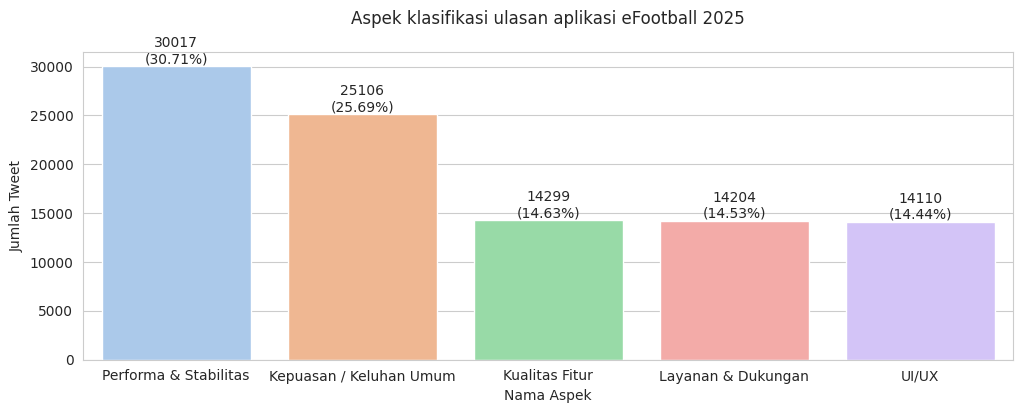

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sentiment_count = data['Kategory'].value_counts()
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette='pastel')
plt.title('Aspek klasifikasi ulasan aplikasi eFootball 2025', fontsize=12, pad=20)
plt.xlabel('Nama Aspek', fontsize=10)
plt.ylabel('Jumlah Tweet', fontsize=10)

total = len(data['Kategory'])

for i, count in enumerate(sentiment_count.values):
    percentage = f'{100 * count / total:.2f}%'
    ax.text(i, count + 0.10, f'{count}\n({percentage})', ha='center', va='bottom')

plt.show()

In [42]:
data.to_csv('Hasil_Aspek_Klasifikasi.csv',encoding='utf8', index=False)

# ***Implementasi Algoritma Indobert***

In [43]:
#  INSTALL DEPENDENCIES
!pip install transformers torch scikit-learn imbalanced-learn seaborn matplotlib tqdm

import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [44]:
#  LOAD DATA
df = pd.read_csv('Hasil_Labelling_Data_scrore2.csv')

df = df.iloc[:2000]

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   stopword removal  2000 non-null   object
 1   score             2000 non-null   int64 
 2   Sentiment         2000 non-null   object
dtypes: int64(1), object(2)
memory usage: 47.0+ KB


,stopword removal,score,Sentiment
0,min hoki kasih epic,5,Positif
1,tolong bikin kebobolan kiper,5,Positif
2,ah kau menciptakan game rusak server sistem ke...,1,Negatif
3,wow,5,Positif
4,eh konami mentang gua topap game lo lo kasih l...,1,Negatif


In [45]:
df = df.dropna(subset=['stopword removal']) # Hapus baris kosong
X_raw = df['stopword removal'].values
y_raw = df['Sentiment'].map({'Negatif': 0, 'Positif': 1}).values

print(f"Jumlah data: {len(X_raw)}")
print(f"Jumlah label: {len(y_raw)}")

Jumlah data: 2000
Jumlah label: 2000


In [46]:
#  INITIALIZE INDOBERT
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
bert_model = BertModel.from_pretrained('indobenchmark/indobert-base-p1').to(device)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:01<?, ?B/s]

In [47]:
#  FEATURE EXTRACTION (CLS EMBEDDING)
def get_embeddings(texts, batch_size=32):
    bert_model.eval()
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting IndoBERT Features"):
        batch_texts = texts[i:i+batch_size].tolist()
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = bert_model(**inputs)
            # Ambil token [CLS] (index 0)
            cls_out = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_out)
    return np.vstack(embeddings)

print("Extracting features (ini mungkin memakan waktu beberapa menit)...")
X_embeddings = get_embeddings(X_raw)

Extracting features (ini mungkin memakan waktu beberapa menit)...



Extracting IndoBERT Features: 100%|██████████| 63/63 [05:43<00:00,  5.46s/it]


In [48]:
#  SPLIT DATA & APPLY SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y_raw, test_size=0.2, random_state=42, stratify=y_raw)

print(f"Original class distribution: {np.bincount(y_train)}")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"Resampled class distribution: {np.bincount(y_train_res)}")

Original class distribution: [892 708]
Resampled class distribution: [892 892]


In [49]:
#  DEFINE NEURAL NETWORK CLASSIFIER
class SentimentClassifier(nn.Module):
    def __init__(self):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(768, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

model = SentimentClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)



In [50]:
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Dataset & DataLoader
train_data = TensorDataset(
    torch.tensor(X_train_res),
    torch.tensor(y_train_res)
)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

epochs = 100
train_losses = []
train_accuracies = []

print("\nStarting Training...")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # ===== Hitung Akurasi =====
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")



Starting Training...
Epoch 1/100 | Loss: 0.5849 | Accuracy: 0.6867
Epoch 2/100 | Loss: 0.4857 | Accuracy: 0.7876
Epoch 3/100 | Loss: 0.4434 | Accuracy: 0.8049
Epoch 4/100 | Loss: 0.4273 | Accuracy: 0.8161
Epoch 5/100 | Loss: 0.4091 | Accuracy: 0.8307
Epoch 6/100 | Loss: 0.4020 | Accuracy: 0.8268
Epoch 7/100 | Loss: 0.3989 | Accuracy: 0.8262
Epoch 8/100 | Loss: 0.3827 | Accuracy: 0.8358
Epoch 9/100 | Loss: 0.3803 | Accuracy: 0.8352
Epoch 10/100 | Loss: 0.3695 | Accuracy: 0.8442
Epoch 11/100 | Loss: 0.3650 | Accuracy: 0.8374
Epoch 12/100 | Loss: 0.3522 | Accuracy: 0.8543
Epoch 13/100 | Loss: 0.3485 | Accuracy: 0.8515
Epoch 14/100 | Loss: 0.3448 | Accuracy: 0.8627
Epoch 15/100 | Loss: 0.3429 | Accuracy: 0.8576
Epoch 16/100 | Loss: 0.3395 | Accuracy: 0.8582
Epoch 17/100 | Loss: 0.3296 | Accuracy: 0.8604
Epoch 18/100 | Loss: 0.3229 | Accuracy: 0.8672
Epoch 19/100 | Loss: 0.3239 | Accuracy: 0.8655
Epoch 20/100 | Loss: 0.3192 | Accuracy: 0.8722
Epoch 21/100 | Loss: 0.3128 | Accuracy: 0.8800


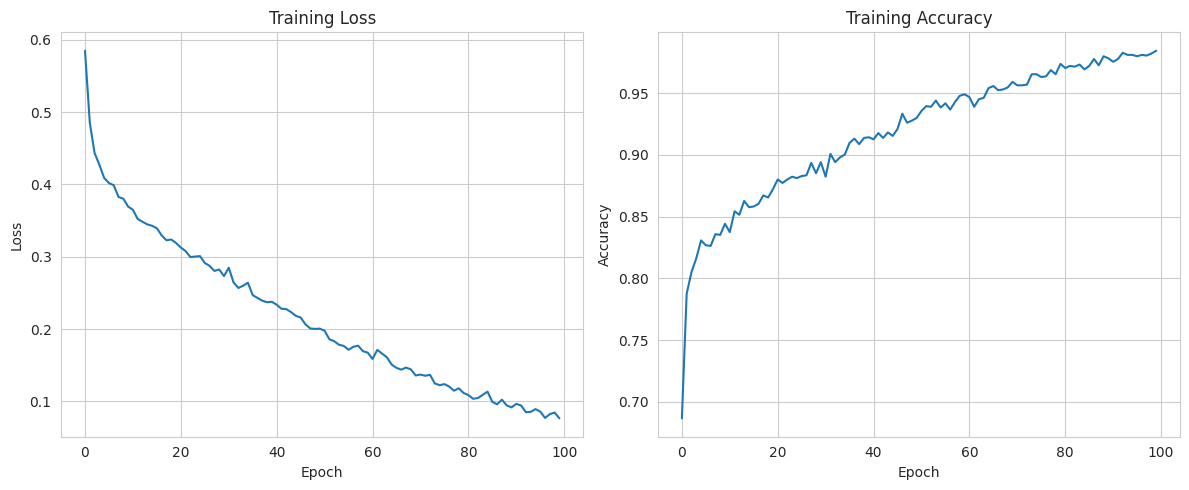

In [51]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [52]:
model.eval()
with torch.no_grad():
    test_outputs = model(torch.tensor(X_test).to(device))
    predictions = torch.argmax(test_outputs, dim=1).cpu().numpy()

# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Metrics
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=['Negatif', 'Positif']))

Accuracy: 0.8100

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.79      0.90      0.84       223
     Positif       0.84      0.70      0.77       177

    accuracy                           0.81       400
   macro avg       0.82      0.80      0.80       400
weighted avg       0.81      0.81      0.81       400



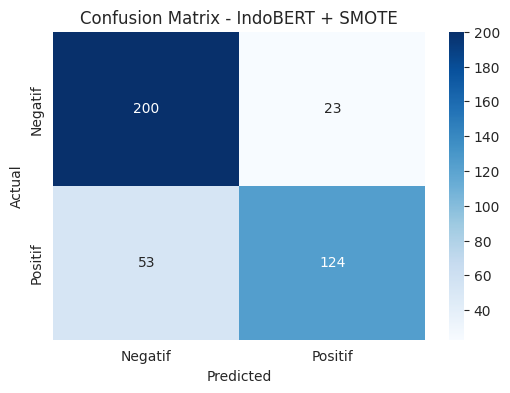

In [53]:
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.title('Confusion Matrix - IndoBERT + SMOTE')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix_indobert.png')
plt.show()